In [106]:
# Análisis de insights clave
print("🔍 INSIGHTS CLAVE DE LOS EXPERIMENTOS\n")
print("=" * 60)

# 1. Mejor rendimiento general
best_tile = df_summary.loc[df_summary['max_tile_mean'].idxmax()]
print(f"\n🏆 Mejor Max Tile Promedio:")
print(f"   {best_tile['name']}")
print(f"   Max Tile: {best_tile['max_tile_mean']:.0f}")
print(f"   Score: {best_tile['score_mean']:.0f}")
print(f"   Win Rate: {best_tile['win_rate']:.1f}%")

# 2. Más victorias
best_wins = df_summary.loc[df_summary['win_rate'].idxmax()]
print(f"\n🎯 Mayor Tasa de Victoria:")
print(f"   {best_wins['name']}")
print(f"   Win Rate: {best_wins['win_rate']:.1f}%")
print(f"   Max Tile: {best_wins['max_tile_mean']:.0f}")

# 3. Más rápido
fastest = df_summary.loc[df_summary['time_mean'].idxmin()]
print(f"\n⚡ Más Rápido (menor tiempo total):")
print(f"   {fastest['name']}")
print(f"   Tiempo: {fastest['time_mean']:.1f}s")
print(f"   Tiempo/movimiento: {fastest['avg_time_per_move_mean']:.3f}s")

# 4. Más eficiente (menos nodos)
efficient = df_summary.loc[df_summary['nodes_mean'].idxmin()]
print(f"\n🎪 Más Eficiente (menos nodos explorados):")
print(f"   {efficient['name']}")
print(f"   Nodos: {efficient['nodes_mean']:.0f}")
print(f"   Max Tile: {efficient['max_tile_mean']:.0f}")

# 5. Impacto de Alpha-Beta
minimax_simple_c1 = df_summary[
    (df_summary['algorithm'] == 'minimax') & 
    (df_summary['heuristic'] == 'simple') &
    (df_summary['config'] == 1)
].copy()

if len(minimax_simple_c1) == 2:
    no_ab = minimax_simple_c1[minimax_simple_c1['alpha_beta'] == False].iloc[0]
    with_ab = minimax_simple_c1[minimax_simple_c1['alpha_beta'] == True].iloc[0]
    
    time_reduction = ((no_ab['time_mean'] - with_ab['time_mean']) / no_ab['time_mean']) * 100
    nodes_reduction = ((no_ab['nodes_mean'] - with_ab['nodes_mean']) / no_ab['nodes_mean']) * 100
    
    print(f"\n📊 Impacto de Alpha-Beta Pruning:")
    print(f"   Reducción de tiempo: {time_reduction:.1f}%")
    print(f"   Reducción de nodos: {nodes_reduction:.1f}%")
    print(f"   Diferencia en Max Tile: {with_ab['max_tile_mean'] - no_ab['max_tile_mean']:.0f}")

# 6. Expectimax vs Minimax
exp_vs_mini = df_summary[
    ((df_summary['algorithm'] == 'expectimax') | 
     ((df_summary['algorithm'] == 'minimax') & (df_summary['alpha_beta'] == True))) &
    (df_summary['heuristic'] == 'simple') &
    (df_summary['config'] == 1)
]

if len(exp_vs_mini) == 2:
    exp = exp_vs_mini[exp_vs_mini['algorithm'] == 'expectimax'].iloc[0]
    mini = exp_vs_mini[exp_vs_mini['algorithm'] == 'minimax'].iloc[0]
    
    print(f"\n🆚 Expectimax vs Minimax AB (Simple, Config 1):")
    print(f"   Expectimax Win Rate: {exp['win_rate']:.1f}%")
    print(f"   Minimax AB Win Rate: {mini['win_rate']:.1f}%")
    print(f"   Diferencia en Max Tile: {exp['max_tile_mean'] - mini['max_tile_mean']:.0f}")
    print(f"   Diferencia en Score: {exp['score_mean'] - mini['score_mean']:.0f}")

print("\n" + "=" * 60)

🔍 INSIGHTS CLAVE DE LOS EXPERIMENTOS


🏆 Mejor Max Tile Promedio:
   Minimax_NoAB_intermediate_c1_d3
   Max Tile: 1318
   Score: 1942
   Win Rate: 40.0%

🎯 Mayor Tasa de Victoria:
   Minimax_NoAB_intermediate_c1_d3
   Win Rate: 40.0%
   Max Tile: 1318

⚡ Más Rápido (menor tiempo total):
   Minimax_AB_simple_c2_d3
   Tiempo: 86.9s
   Tiempo/movimiento: 0.163s

🎪 Más Eficiente (menos nodos explorados):
   Minimax_AB_simple_c2_d3
   Nodos: 498687
   Max Tile: 627

📊 Impacto de Alpha-Beta Pruning:
   Reducción de tiempo: 75.5%
   Reducción de nodos: 82.5%
   Diferencia en Max Tile: 154

🆚 Expectimax vs Minimax AB (Simple, Config 1):
   Expectimax Win Rate: 35.0%
   Minimax AB Win Rate: 0.0%
   Diferencia en Max Tile: 486
   Diferencia en Score: 402



## 📦 1. Importación y Carga de Datos

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas")

✅ Librerías importadas


In [108]:
# Cargar datos
results_dir = Path('results')

# Buscar solo archivos de experimentos (depth 3)
csv_files = [
    f for f in results_dir.glob('*.csv')
    if not f.name.startswith(('baseline', 'alpha_beta_comparison', 'expectimax_depth',
                               'minimax_depth', 'expectimax_heuristic', 'summary', 'ranking'))
    and 'd3' in f.name  # Solo depth 3
]

print(f"📁 Archivos encontrados: {len(csv_files)}")
for f in sorted(csv_files):
    print(f"   - {f.name}")

# Cargar todos los datos
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    
    # Renombrar columnas si es necesario
    if 'time_seconds' in df.columns:
        df = df.rename(columns={'time_seconds': 'time'})
    if 'final_score' in df.columns:
        df = df.rename(columns={'final_score': 'score'})
    
    # Extraer metadata del nombre del archivo
    if 'Minimax' in csv_file.name:
        df['algorithm'] = 'Minimax'
        # Verificar si es Minimax con AB (debe tener '_AB_' y NO '_NoAB_')
        df['alpha_beta'] = '_AB_' in csv_file.name and '_NoAB_' not in csv_file.name
    elif 'Expectimax' in csv_file.name:
        df['algorithm'] = 'Expectimax'
        df['alpha_beta'] = False
    
    # Heurística
    for heur in ['simple', 'intermediate', 'complex']:
        if heur in csv_file.name.lower():
            df['heuristic'] = heur
            break
    
    # Config
    if 'c1' in csv_file.name:
        df['config'] = 'c1'
    elif 'c2' in csv_file.name:
        df['config'] = 'c2'
    
    dfs.append(df)

# Combinar
df_all = pd.concat(dfs, ignore_index=True)

# Crear etiqueta única para cada configuración
df_all['label'] = df_all.apply(
    lambda row: f"{row['heuristic']} {row['config']}",
    axis=1
)

# Crear etiqueta de algoritmo completa
df_all['algo_label'] = df_all.apply(
    lambda row: f"{row['algorithm']} {'AB' if row['alpha_beta'] else 'NoAB'}" if row['algorithm'] == 'Minimax' else row['algorithm'],
    axis=1
)

print(f"\n📊 Total partidas: {len(df_all)}")
print(f"Algoritmos: {df_all['algo_label'].unique()}")
print(f"Configuraciones: {sorted(df_all['label'].unique())}")
print(f"\n📋 Columnas disponibles: {list(df_all.columns)}")
display(df_all.head())

📁 Archivos encontrados: 8
   - Expectimax_simple_c1_d3_20251214_150242.csv
   - Expectimax_simple_c2_d3_20251214_213946.csv
   - Minimax_AB_intermediate_c1_d3_20251215_082710.csv
   - Minimax_AB_simple_c1_d3_20251214_112122.csv
   - Minimax_AB_simple_c2_d3_20251214_180347.csv
   - Minimax_NoAB_intermediate_c1_d3_20251215_072336.csv
   - Minimax_NoAB_simple_c1_d3_20251214_104808.csv
   - Minimax_NoAB_simple_c2_d3_20251214_173448.csv

📊 Total partidas: 160
Algoritmos: ['Expectimax' 'Minimax AB' 'Minimax NoAB']
Configuraciones: ['intermediate c1', 'simple c1', 'simple c2']

📋 Columnas disponibles: ['game_id', 'agent_name', 'max_tile', 'score', 'moves', 'time', 'won', 'nodes_explored', 'avg_time_per_move', 'timestamp', 'depth', 'heuristic', 'config', 'alpha_beta', 'algorithm', 'pruned_nodes', 'label', 'algo_label']


,game_id,agent_name,max_tile,score,moves,time,won,nodes_explored,avg_time_per_move,timestamp,depth,heuristic,config,alpha_beta,algorithm,pruned_nodes,label,algo_label
0,0,Expectimax_simple_c1_d3,2048,2136,958,790.04,True,6325497,0.82,2025-12-14T11:34:32.820558,3,simple,c1,False,Expectimax,NaN,simple c1,Expectimax
1,1,Expectimax_simple_c1_d3,2048,2132,972,818.82,True,6592285,0.84,2025-12-14T11:48:11.639168,3,simple,c1,False,Expectimax,NaN,simple c1,Expectimax
2,2,Expectimax_simple_c1_d3,1024,2168,977,768.96,False,6186510,0.79,2025-12-14T12:01:00.602355,3,simple,c1,False,Expectimax,NaN,simple c1,Expectimax
3,3,Expectimax_simple_c1_d3,2048,2132,967,801.69,True,6439540,0.83,2025-12-14T12:14:22.294464,3,simple,c1,False,Expectimax,NaN,simple c1,Expectimax
4,4,Expectimax_simple_c1_d3,2048,2202,1000,731.51,True,5878472,0.73,2025-12-14T12:26:33.802356,3,simple,c1,False,Expectimax,NaN,simple c1,Expectimax


## 📊 2. Estadísticas por Configuración

In [109]:
# Calcular estadísticas completas por algoritmo y configuración
stats = df_all.groupby(['algo_label', 'heuristic', 'config']).agg({
    'max_tile': ['mean', 'std', 'max'],
    'score': ['mean', 'std', 'max'],
    'moves': ['mean', 'std'],
    'time': ['mean', 'std'],
    'nodes_explored': ['mean', 'std'],
    'avg_time_per_move': ['mean', 'std'],
    'won': 'sum',
    'game_id': 'count'
}).round(2)

stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = stats.rename(columns={'game_id_count': 'n_games', 'won_sum': 'victories'})
stats = stats.reset_index()
stats['label'] = stats['heuristic'] + ' ' + stats['config']
stats['victory_rate'] = (stats['victories'] / stats['n_games'] * 100).round(1)

# Añadir columna de pruned_nodes para Minimax AB
if 'pruned_nodes' in df_all.columns:
    pruned_stats = df_all[df_all['alpha_beta'] == True].groupby(['algo_label', 'heuristic', 'config']).agg({
        'pruned_nodes': ['mean', 'std']
    }).round(0)
    pruned_stats.columns = ['pruned_nodes_mean', 'pruned_nodes_std']
    pruned_stats = pruned_stats.reset_index()
    stats = stats.merge(pruned_stats, on=['algo_label', 'heuristic', 'config'], how='left')

print("📊 ESTADÍSTICAS COMPLETAS POR CONFIGURACIÓN")
print("=" * 120)
display(stats.sort_values('score_mean', ascending=False))

📊 ESTADÍSTICAS COMPLETAS POR CONFIGURACIÓN


,algo_label,heuristic,config,max_tile_mean,max_tile_std,max_tile_max,score_mean,score_std,score_max,moves_mean,...,nodes_explored_mean,nodes_explored_std,avg_time_per_move_mean,avg_time_per_move_std,victories,n_games,label,victory_rate,pruned_nodes_mean,pruned_nodes_std
2,Minimax AB,intermediate,c1,1280.00,610.34,2048,1960.90,463.81,2448,892.55,...,848188.50,205368.66,0.21,0.02,7,20,intermediate c1,35.00,92.00,137.00
5,Minimax NoAB,intermediate,c1,1318.40,650.16,2048,1941.50,497.96,2560,876.85,...,5170994.55,1096239.51,3.35,10.04,8,20,intermediate c1,40.00,NaN,NaN
0,Expectimax,simple,c1,1254.40,632.00,2048,1812.90,446.63,2206,821.90,...,5345286.05,1180502.40,0.82,0.05,7,20,simple c1,35.00,NaN,NaN
1,Expectimax,simple,c2,1075.20,466.90,2048,1795.70,419.12,2380,815.50,...,5201056.50,1012542.14,0.81,0.07,3,20,simple c2,15.00,NaN,NaN
3,Minimax AB,simple,c1,768.00,299.47,1024,1411.30,465.18,2226,639.80,...,572203.35,165156.67,0.16,0.01,0,20,simple c1,0.00,4.00,2.00
7,Minimax NoAB,simple,c2,691.20,288.92,1024,1276.70,403.70,1944,576.45,...,3673472.55,939954.00,0.81,0.08,0,20,simple c2,0.00,NaN,NaN
4,Minimax AB,simple,c2,627.20,241.80,1024,1188.50,320.76,2086,538.80,...,498687.20,116065.46,0.16,0.01,0,20,simple c2,0.00,5.00,5.00
6,Minimax NoAB,simple,c1,614.40,325.94,1024,1123.90,448.64,1846,507.70,...,3274487.20,1107901.98,0.83,0.09,0,20,simple c1,0.00,NaN,NaN


## Comparaciones Simplificadas por Archivo CSV

Análisis directo de los archivos CSV específicos

In [110]:
# Cargar archivos CSV específicos
csv_files_dict = {
    'Minimax_NoAB_simple_c1_d3': results_dir / 'Minimax_NoAB_simple_c1_d3_20251214_104808.csv',
    'Minimax_NoAB_simple_c2_d3': results_dir / 'Minimax_NoAB_simple_c2_d3_20251214_173448.csv',
    'Minimax_NoAB_intermediate_c1_d3': results_dir / 'Minimax_NoAB_intermediate_c1_d3_20251215_072336.csv',
    'Minimax_AB_simple_c1_d3': results_dir / 'Minimax_AB_simple_c1_d3_20251214_112122.csv',
    'Minimax_AB_simple_c2_d3': results_dir / 'Minimax_AB_simple_c2_d3_20251214_180347.csv',
    'Minimax_AB_intermediate_c1_d3': results_dir / 'Minimax_AB_intermediate_c1_d3_20251215_082710.csv',
    'Expectimax_simple_c1_d3': results_dir / 'Expectimax_simple_c1_d3_20251214_150242.csv',
    'Expectimax_simple_c2_d3': results_dir / 'Expectimax_simple_c2_d3_20251214_213946.csv',
}

# Cargar y procesar datos
data_summary = []
for name, filepath in csv_files_dict.items():
    if filepath.exists():
        df_temp = pd.read_csv(filepath)
        summary = {
            'name': name,
            'algorithm': df_temp['algorithm'].iloc[0],
            'heuristic': df_temp['heuristic'].iloc[0],
            'config': df_temp['config'].iloc[0],
            'alpha_beta': df_temp['alpha_beta'].iloc[0] if 'alpha_beta' in df_temp.columns else False,
            'depth': df_temp['depth'].iloc[0],
            # Estadísticas
            'max_tile_mean': df_temp['max_tile'].mean(),
            'max_tile_std': df_temp['max_tile'].std(),
            'score_mean': df_temp['final_score'].mean(),
            'score_std': df_temp['final_score'].std(),
            'moves_mean': df_temp['moves'].mean(),
            'moves_std': df_temp['moves'].std(),
            'time_mean': df_temp['time_seconds'].mean(),
            'time_std': df_temp['time_seconds'].std(),
            'nodes_mean': df_temp['nodes_explored'].mean(),
            'nodes_std': df_temp['nodes_explored'].std(),
            'avg_time_per_move_mean': df_temp['avg_time_per_move'].mean(),
            'avg_time_per_move_std': df_temp['avg_time_per_move'].std(),
            'win_rate': df_temp['won'].mean() * 100,
            'games': len(df_temp)
        }
        data_summary.append(summary)

df_summary = pd.DataFrame(data_summary)
print(f"✅ Cargados {len(df_summary)} experimentos")
df_summary[['name', 'algorithm', 'heuristic', 'config', 'alpha_beta', 'max_tile_mean', 'score_mean', 'win_rate']]

✅ Cargados 8 experimentos


,name,algorithm,heuristic,config,alpha_beta,max_tile_mean,score_mean,win_rate
0,Minimax_NoAB_simple_c1_d3,minimax,simple,1,False,614.40,1123.90,0.00
1,Minimax_NoAB_simple_c2_d3,minimax,simple,2,False,691.20,1276.70,0.00
2,Minimax_NoAB_intermediate_c1_d3,minimax,intermediate,1,False,1318.40,1941.50,40.00
3,Minimax_AB_simple_c1_d3,minimax,simple,1,True,768.00,1411.30,0.00
4,Minimax_AB_simple_c2_d3,minimax,simple,2,True,627.20,1188.50,0.00
5,Minimax_AB_intermediate_c1_d3,minimax,intermediate,1,True,1280.00,1960.90,35.00
6,Expectimax_simple_c1_d3,expectimax,simple,1,False,1254.40,1812.90,35.00
7,Expectimax_simple_c2_d3,expectimax,simple,2,False,1075.20,1795.70,15.00


### 1. Comparación: Minimax con/sin Alpha-Beta (Heurística Simple)

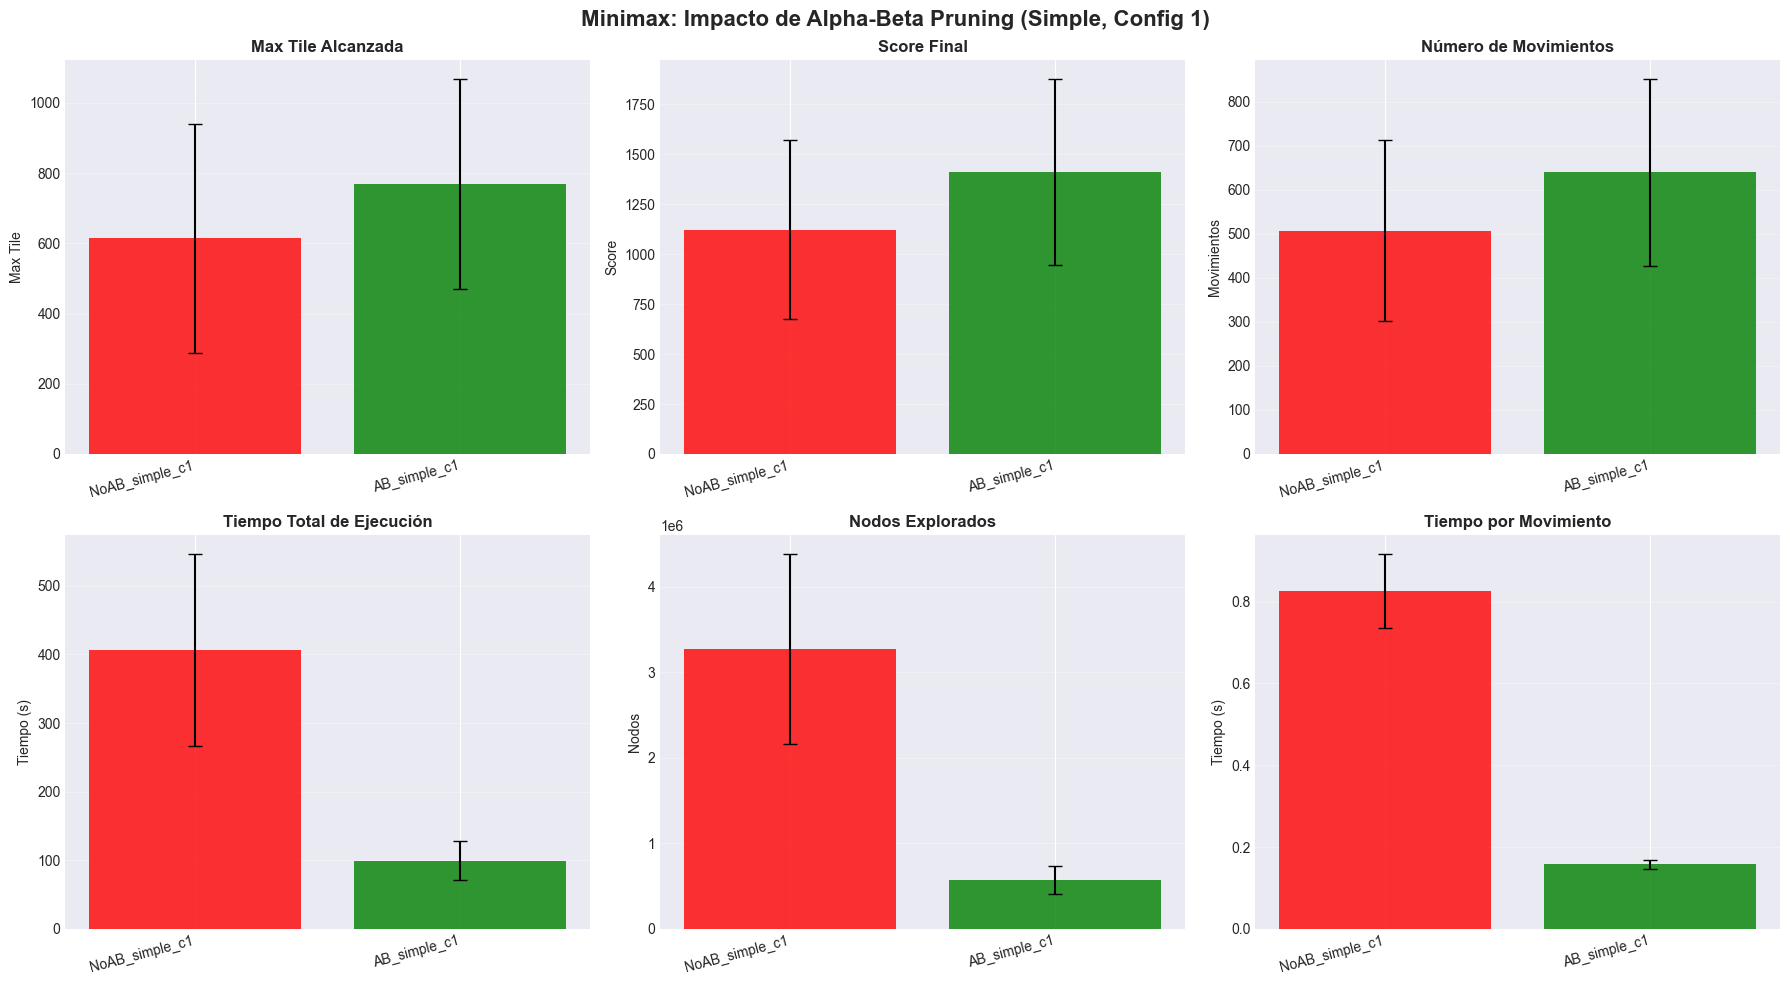

✅ Comparación Alpha-Beta generada (guardada como fig1_alpha_beta_comparison.png)


In [119]:
# Comparar Minimax con/sin Alpha-Beta (heurística simple, config 1)
comparison_ab = df_summary[
    (df_summary['algorithm'] == 'minimax') & 
    (df_summary['heuristic'] == 'simple') &
    (df_summary['config'] == 1)
].copy()

if len(comparison_ab) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    x_labels = comparison_ab['name'].str.replace('Minimax_', '').str.replace('_d3', '')
    x_pos = range(len(comparison_ab))
    
    # 1. Max Tile
    axes[0].bar(x_pos, comparison_ab['max_tile_mean'], yerr=comparison_ab['max_tile_std'], 
                capsize=5, alpha=0.8, color=['red', 'green'])
    axes[0].set_title('Max Tile Alcanzada', fontweight='bold')
    axes[0].set_ylabel('Max Tile')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(x_labels, rotation=15, ha='right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Score Final
    axes[1].bar(x_pos, comparison_ab['score_mean'], yerr=comparison_ab['score_std'], 
                capsize=5, alpha=0.8, color=['red', 'green'])
    axes[1].set_title('Score Final', fontweight='bold')
    axes[1].set_ylabel('Score')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(x_labels, rotation=15, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Movimientos
    axes[2].bar(x_pos, comparison_ab['moves_mean'], yerr=comparison_ab['moves_std'], 
                capsize=5, alpha=0.8, color=['red', 'green'])
    axes[2].set_title('Número de Movimientos', fontweight='bold')
    axes[2].set_ylabel('Movimientos')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(x_labels, rotation=15, ha='right')
    axes[2].grid(axis='y', alpha=0.3)
    
    # 4. Tiempo Total
    axes[3].bar(x_pos, comparison_ab['time_mean'], yerr=comparison_ab['time_std'], 
                capsize=5, alpha=0.8, color=['red', 'green'])
    axes[3].set_title('Tiempo Total de Ejecución', fontweight='bold')
    axes[3].set_ylabel('Tiempo (s)')
    axes[3].set_xticks(x_pos)
    axes[3].set_xticklabels(x_labels, rotation=15, ha='right')
    axes[3].grid(axis='y', alpha=0.3)
    
    # 5. Nodos Explorados
    axes[4].bar(x_pos, comparison_ab['nodes_mean'], yerr=comparison_ab['nodes_std'], 
                capsize=5, alpha=0.8, color=['red', 'green'])
    axes[4].set_title('Nodos Explorados', fontweight='bold')
    axes[4].set_ylabel('Nodos')
    axes[4].set_xticks(x_pos)
    axes[4].set_xticklabels(x_labels, rotation=15, ha='right')
    axes[4].grid(axis='y', alpha=0.3)
    axes[4].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 6. Tiempo por Movimiento
    axes[5].bar(x_pos, comparison_ab['avg_time_per_move_mean'], 
                yerr=comparison_ab['avg_time_per_move_std'], 
                capsize=5, alpha=0.8, color=['red', 'green'])
    axes[5].set_title('Tiempo por Movimiento', fontweight='bold')
    axes[5].set_ylabel('Tiempo (s)')
    axes[5].set_xticks(x_pos)
    axes[5].set_xticklabels(x_labels, rotation=15, ha='right')
    axes[5].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Minimax: Impacto de Alpha-Beta Pruning (Simple, Config 1)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/plots/fig1_alpha_beta_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Comparación Alpha-Beta generada (guardada como fig1_alpha_beta_comparison.png)")
else:
    print("⚠️ No hay suficientes datos")

### 2. Comparación: Diferentes Configuraciones (Minimax con Alpha-Beta, Simple)

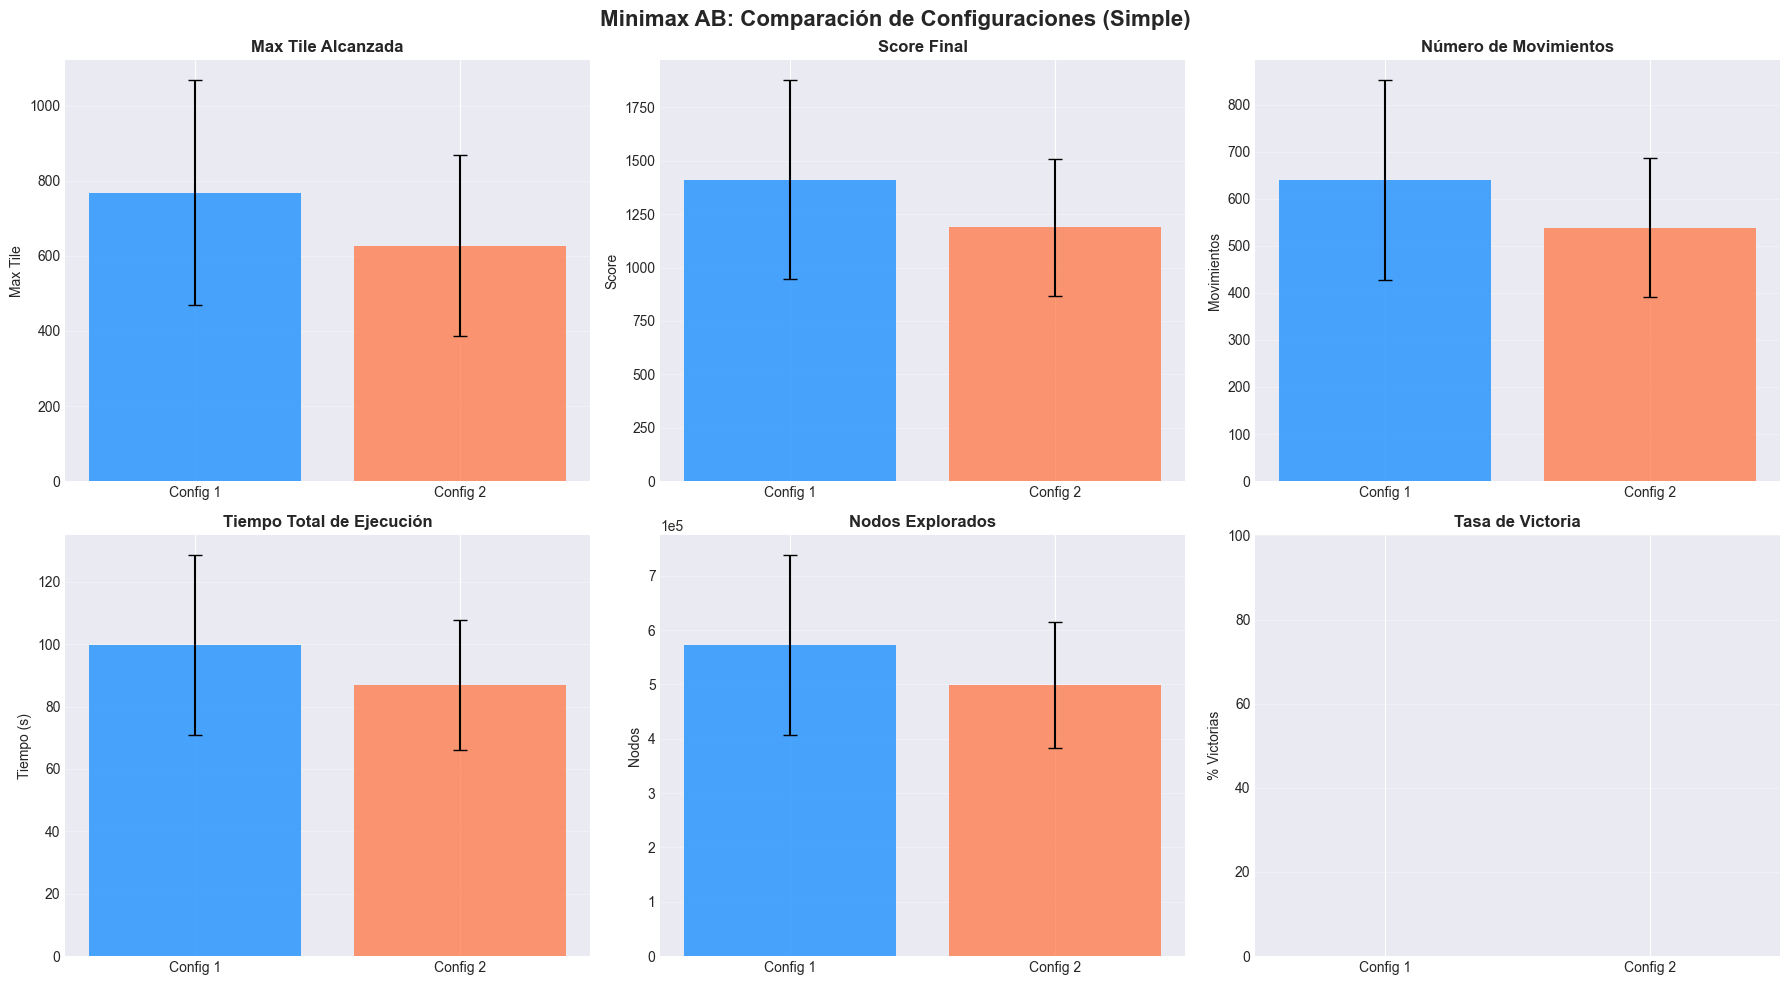

✅ Comparación de configuraciones generada (guardada como fig2_configuration_comparison.png)


In [120]:
# Comparar diferentes configuraciones (Minimax AB, simple)
comparison_config = df_summary[
    (df_summary['algorithm'] == 'minimax') & 
    (df_summary['heuristic'] == 'simple') &
    (df_summary['alpha_beta'] == True)
].copy()

if len(comparison_config) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    x_labels = ['Config ' + str(int(c)) for c in comparison_config['config']]
    x_pos = range(len(comparison_config))
    
    # 1. Max Tile
    axes[0].bar(x_pos, comparison_config['max_tile_mean'], 
                yerr=comparison_config['max_tile_std'], 
                capsize=5, alpha=0.8, color=['dodgerblue', 'coral'])
    axes[0].set_title('Max Tile Alcanzada', fontweight='bold')
    axes[0].set_ylabel('Max Tile')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(x_labels)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Score Final
    axes[1].bar(x_pos, comparison_config['score_mean'], 
                yerr=comparison_config['score_std'], 
                capsize=5, alpha=0.8, color=['dodgerblue', 'coral'])
    axes[1].set_title('Score Final', fontweight='bold')
    axes[1].set_ylabel('Score')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(x_labels)
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Movimientos
    axes[2].bar(x_pos, comparison_config['moves_mean'], 
                yerr=comparison_config['moves_std'], 
                capsize=5, alpha=0.8, color=['dodgerblue', 'coral'])
    axes[2].set_title('Número de Movimientos', fontweight='bold')
    axes[2].set_ylabel('Movimientos')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(x_labels)
    axes[2].grid(axis='y', alpha=0.3)
    
    # 4. Tiempo Total
    axes[3].bar(x_pos, comparison_config['time_mean'], 
                yerr=comparison_config['time_std'], 
                capsize=5, alpha=0.8, color=['dodgerblue', 'coral'])
    axes[3].set_title('Tiempo Total de Ejecución', fontweight='bold')
    axes[3].set_ylabel('Tiempo (s)')
    axes[3].set_xticks(x_pos)
    axes[3].set_xticklabels(x_labels)
    axes[3].grid(axis='y', alpha=0.3)
    
    # 5. Nodos Explorados
    axes[4].bar(x_pos, comparison_config['nodes_mean'], 
                yerr=comparison_config['nodes_std'], 
                capsize=5, alpha=0.8, color=['dodgerblue', 'coral'])
    axes[4].set_title('Nodos Explorados', fontweight='bold')
    axes[4].set_ylabel('Nodos')
    axes[4].set_xticks(x_pos)
    axes[4].set_xticklabels(x_labels)
    axes[4].grid(axis='y', alpha=0.3)
    axes[4].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 6. Tasa de Victoria
    axes[5].bar(x_pos, comparison_config['win_rate'], 
                capsize=5, alpha=0.8, color=['dodgerblue', 'coral'])
    axes[5].set_title('Tasa de Victoria', fontweight='bold')
    axes[5].set_ylabel('% Victorias')
    axes[5].set_xticks(x_pos)
    axes[5].set_xticklabels(x_labels)
    axes[5].set_ylim([0, 100])
    axes[5].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Minimax AB: Comparación de Configuraciones (Simple)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/plots/fig2_configuration_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Comparación de configuraciones generada (guardada como fig2_configuration_comparison.png)")
else:
    print("⚠️ No hay suficientes datos")

### 3. Comparación: Heurísticas (Minimax AB, Config 1)

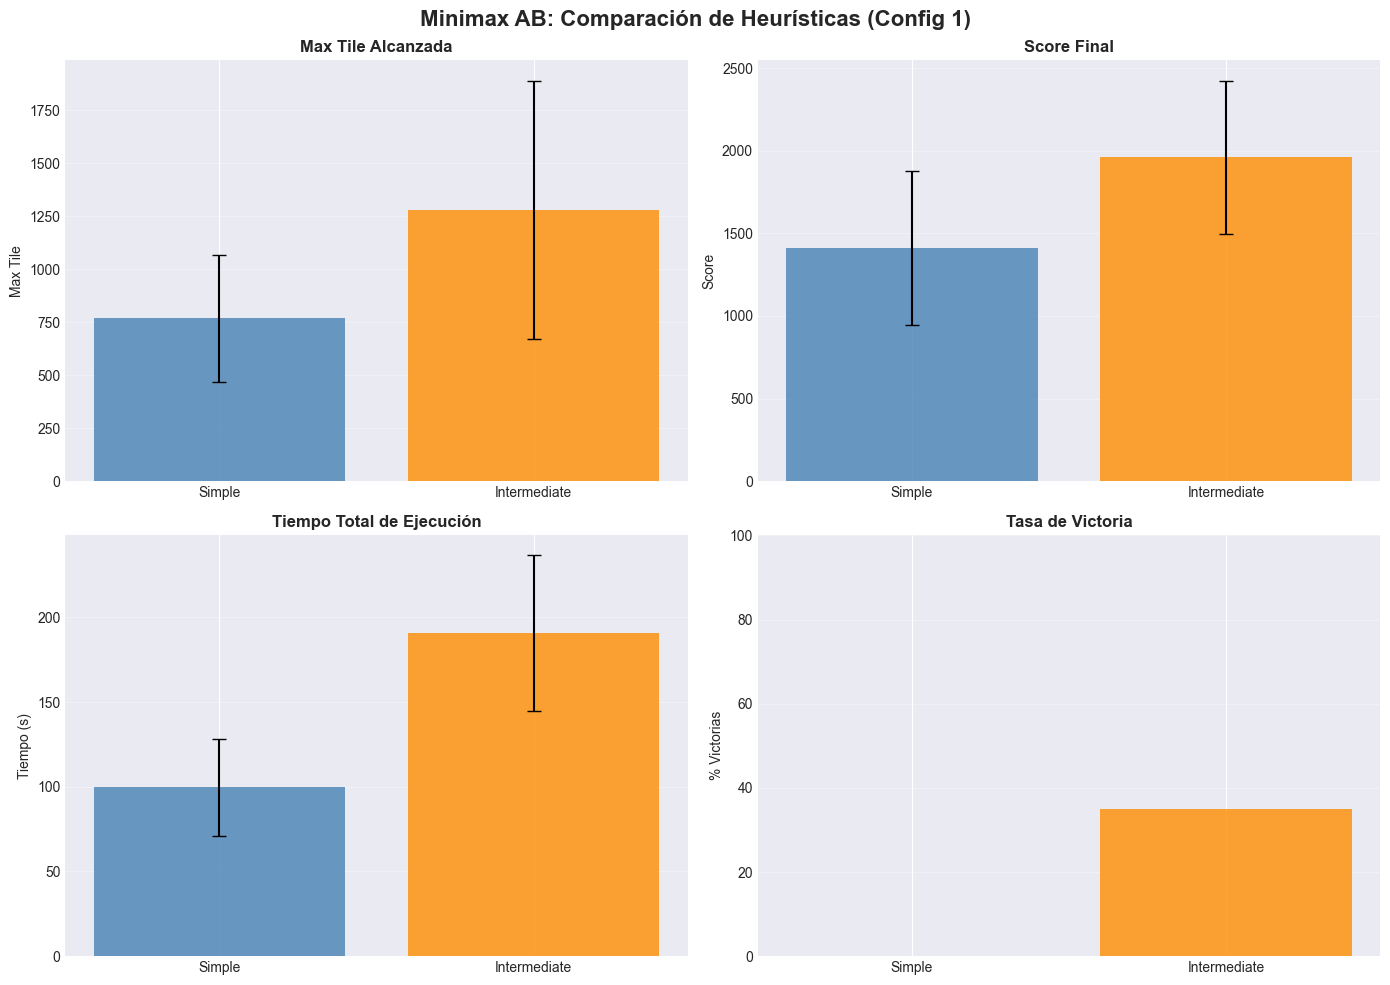

✅ Comparación de heurísticas generada (guardada como fig3_heuristics_comparison.png)


In [121]:
# Comparar heurísticas (Minimax AB, config 1)
comparison_heur = df_summary[
    (df_summary['algorithm'] == 'minimax') & 
    (df_summary['alpha_beta'] == True) &
    (df_summary['config'] == 1)
].copy()

if len(comparison_heur) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    x_labels = [h.capitalize() for h in comparison_heur['heuristic']]
    x_pos = range(len(comparison_heur))
    colors = ['steelblue', 'darkorange']
    
    # 1. Max Tile
    axes[0].bar(x_pos, comparison_heur['max_tile_mean'], 
                yerr=comparison_heur['max_tile_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_heur)])
    axes[0].set_title('Max Tile Alcanzada', fontweight='bold')
    axes[0].set_ylabel('Max Tile')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(x_labels)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Score Final
    axes[1].bar(x_pos, comparison_heur['score_mean'], 
                yerr=comparison_heur['score_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_heur)])
    axes[1].set_title('Score Final', fontweight='bold')
    axes[1].set_ylabel('Score')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(x_labels)
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Tiempo Total
    axes[2].bar(x_pos, comparison_heur['time_mean'], 
                yerr=comparison_heur['time_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_heur)])
    axes[2].set_title('Tiempo Total de Ejecución', fontweight='bold')
    axes[2].set_ylabel('Tiempo (s)')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(x_labels)
    axes[2].grid(axis='y', alpha=0.3)
    
    # 4. Tasa de Victoria
    axes[3].bar(x_pos, comparison_heur['win_rate'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_heur)])
    axes[3].set_title('Tasa de Victoria', fontweight='bold')
    axes[3].set_ylabel('% Victorias')
    axes[3].set_xticks(x_pos)
    axes[3].set_xticklabels(x_labels)
    axes[3].set_ylim([0, 100])
    axes[3].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Minimax AB: Comparación de Heurísticas (Config 1)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/plots/fig3_heuristics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Comparación de heurísticas generada (guardada como fig3_heuristics_comparison.png)")
else:
    print("⚠️ No hay suficientes datos")

### 4. Comparación: Expectimax vs Minimax (Simple, Config 1)

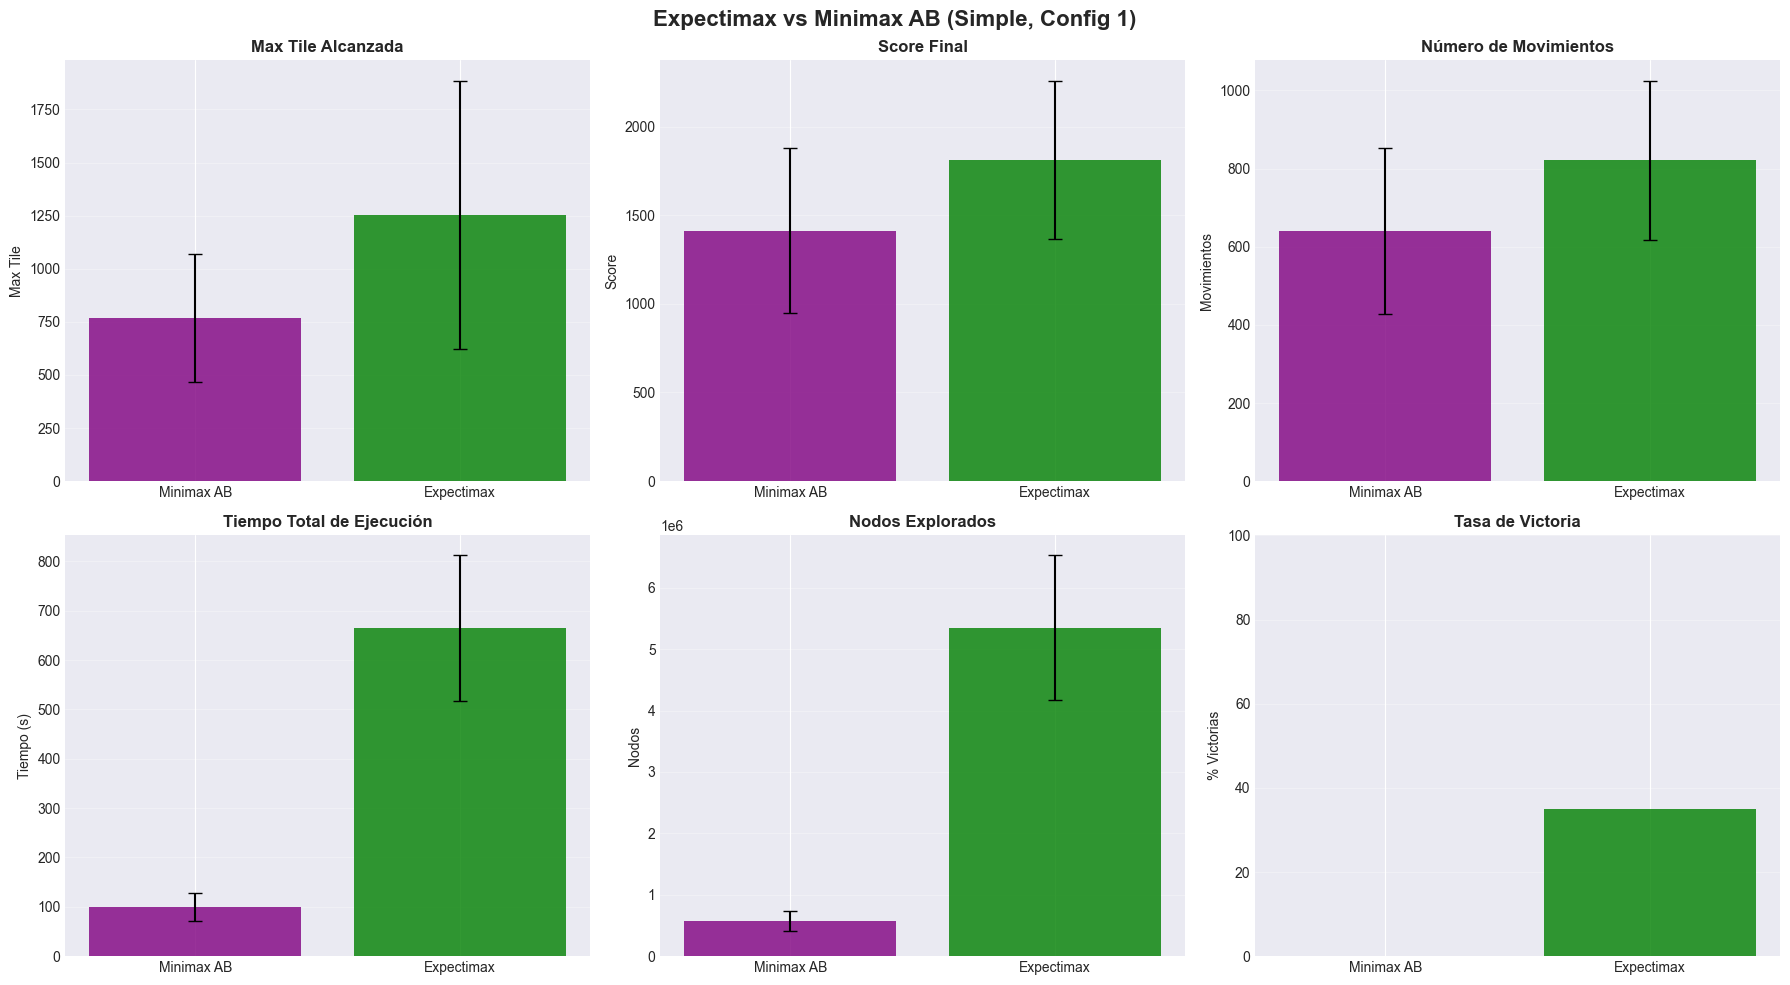

✅ Comparación Expectimax vs Minimax generada (guardada como fig4_expectimax_vs_minimax.png)


In [122]:
# Comparar Expectimax vs Minimax AB (simple, config 1)
comparison_algo = df_summary[
    ((df_summary['algorithm'] == 'expectimax') | 
     ((df_summary['algorithm'] == 'minimax') & (df_summary['alpha_beta'] == True))) &
    (df_summary['heuristic'] == 'simple') &
    (df_summary['config'] == 1)
].copy()

if len(comparison_algo) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    x_labels = [('Expectimax' if a == 'expectimax' else 'Minimax AB') 
                for a in comparison_algo['algorithm']]
    x_pos = range(len(comparison_algo))
    colors = ['purple', 'green']
    
    # 1. Max Tile
    axes[0].bar(x_pos, comparison_algo['max_tile_mean'], 
                yerr=comparison_algo['max_tile_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_algo)])
    axes[0].set_title('Max Tile Alcanzada', fontweight='bold')
    axes[0].set_ylabel('Max Tile')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(x_labels)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Score Final
    axes[1].bar(x_pos, comparison_algo['score_mean'], 
                yerr=comparison_algo['score_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_algo)])
    axes[1].set_title('Score Final', fontweight='bold')
    axes[1].set_ylabel('Score')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(x_labels)
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Movimientos
    axes[2].bar(x_pos, comparison_algo['moves_mean'], 
                yerr=comparison_algo['moves_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_algo)])
    axes[2].set_title('Número de Movimientos', fontweight='bold')
    axes[2].set_ylabel('Movimientos')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(x_labels)
    axes[2].grid(axis='y', alpha=0.3)
    
    # 4. Tiempo Total
    axes[3].bar(x_pos, comparison_algo['time_mean'], 
                yerr=comparison_algo['time_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_algo)])
    axes[3].set_title('Tiempo Total de Ejecución', fontweight='bold')
    axes[3].set_ylabel('Tiempo (s)')
    axes[3].set_xticks(x_pos)
    axes[3].set_xticklabels(x_labels)
    axes[3].grid(axis='y', alpha=0.3)
    
    # 5. Nodos Explorados
    axes[4].bar(x_pos, comparison_algo['nodes_mean'], 
                yerr=comparison_algo['nodes_std'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_algo)])
    axes[4].set_title('Nodos Explorados', fontweight='bold')
    axes[4].set_ylabel('Nodos')
    axes[4].set_xticks(x_pos)
    axes[4].set_xticklabels(x_labels)
    axes[4].grid(axis='y', alpha=0.3)
    axes[4].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 6. Tasa de Victoria
    axes[5].bar(x_pos, comparison_algo['win_rate'], 
                capsize=5, alpha=0.8, color=colors[:len(comparison_algo)])
    axes[5].set_title('Tasa de Victoria', fontweight='bold')
    axes[5].set_ylabel('% Victorias')
    axes[5].set_xticks(x_pos)
    axes[5].set_xticklabels(x_labels)
    axes[5].set_ylim([0, 100])
    axes[5].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Expectimax vs Minimax AB (Simple, Config 1)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/plots/fig4_expectimax_vs_minimax.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Comparación Expectimax vs Minimax generada (guardada como fig4_expectimax_vs_minimax.png)")
else:
    print("⚠️ No hay suficientes datos")

### 5. Resumen General: Todos los Experimentos

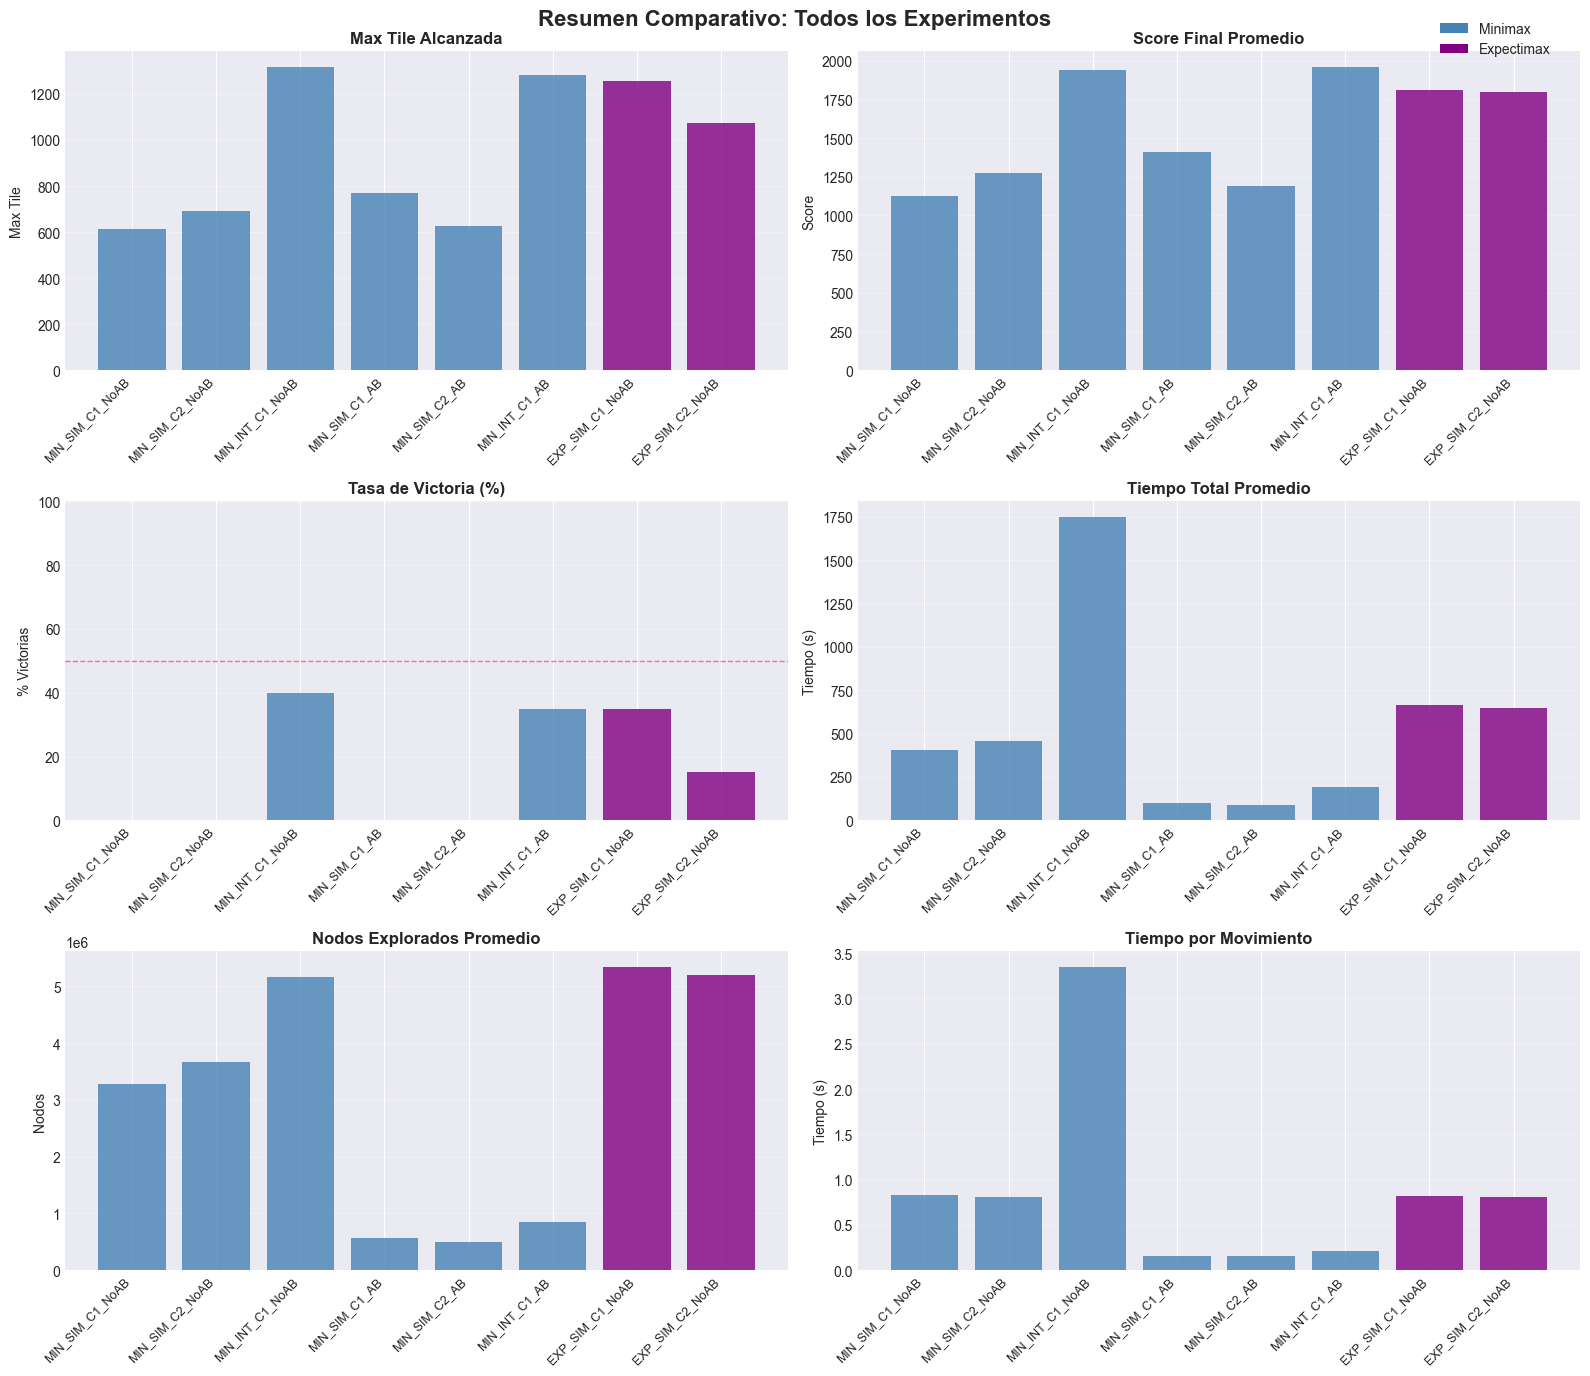

✅ Resumen general generado (guardada como fig5_general_summary.png)


In [123]:
# Crear visualización general de todos los experimentos
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

# Crear etiquetas más cortas
df_summary['short_label'] = (
    df_summary['algorithm'].str[:3].str.upper() + '_' +
    df_summary['heuristic'].str[:3].str.upper() + '_' +
    'C' + df_summary['config'].astype(str) + '_' +
    df_summary['alpha_beta'].apply(lambda x: 'AB' if x else 'NoAB')
)

x_pos = range(len(df_summary))
colors_map = {
    'minimax': 'steelblue',
    'expectimax': 'purple'
}
bar_colors = [colors_map.get(alg, 'gray') for alg in df_summary['algorithm']]

# 1. Max Tile
axes[0].bar(x_pos, df_summary['max_tile_mean'], alpha=0.8, color=bar_colors)
axes[0].set_title('Max Tile Alcanzada', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Max Tile')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(df_summary['short_label'], rotation=45, ha='right', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# 2. Score
axes[1].bar(x_pos, df_summary['score_mean'], alpha=0.8, color=bar_colors)
axes[1].set_title('Score Final Promedio', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(df_summary['short_label'], rotation=45, ha='right', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

# 3. Tasa de Victoria
axes[2].bar(x_pos, df_summary['win_rate'], alpha=0.8, color=bar_colors)
axes[2].set_title('Tasa de Victoria (%)', fontweight='bold', fontsize=12)
axes[2].set_ylabel('% Victorias')
axes[2].set_ylim([0, 100])
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(df_summary['short_label'], rotation=45, ha='right', fontsize=9)
axes[2].grid(axis='y', alpha=0.3)
axes[2].axhline(50, color='red', linestyle='--', alpha=0.5, linewidth=1)

# 4. Tiempo Total
axes[3].bar(x_pos, df_summary['time_mean'], alpha=0.8, color=bar_colors)
axes[3].set_title('Tiempo Total Promedio', fontweight='bold', fontsize=12)
axes[3].set_ylabel('Tiempo (s)')
axes[3].set_xticks(x_pos)
axes[3].set_xticklabels(df_summary['short_label'], rotation=45, ha='right', fontsize=9)
axes[3].grid(axis='y', alpha=0.3)

# 5. Nodos Explorados
axes[4].bar(x_pos, df_summary['nodes_mean'], alpha=0.8, color=bar_colors)
axes[4].set_title('Nodos Explorados Promedio', fontweight='bold', fontsize=12)
axes[4].set_ylabel('Nodos')
axes[4].set_xticks(x_pos)
axes[4].set_xticklabels(df_summary['short_label'], rotation=45, ha='right', fontsize=9)
axes[4].grid(axis='y', alpha=0.3)
axes[4].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 6. Tiempo por Movimiento
axes[5].bar(x_pos, df_summary['avg_time_per_move_mean'], alpha=0.8, color=bar_colors)
axes[5].set_title('Tiempo por Movimiento', fontweight='bold', fontsize=12)
axes[5].set_ylabel('Tiempo (s)')
axes[5].set_xticks(x_pos)
axes[5].set_xticklabels(df_summary['short_label'], rotation=45, ha='right', fontsize=9)
axes[5].grid(axis='y', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Minimax'),
    Patch(facecolor='purple', label='Expectimax')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

fig.suptitle('Resumen Comparativo: Todos los Experimentos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('results/plots/fig5_general_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Resumen general generado (guardada como fig5_general_summary.png)")

### 6. Tabla Resumen de Resultados

In [118]:
# Tabla resumen con las métricas principales
summary_table = df_summary[[
    'name', 'algorithm', 'heuristic', 'config', 'alpha_beta',
    'max_tile_mean', 'score_mean', 'win_rate', 'time_mean', 'nodes_mean'
]].copy()

summary_table.columns = [
    'Experimento', 'Algoritmo', 'Heurística', 'Config', 'Alpha-Beta',
    'Max Tile', 'Score', 'Win %', 'Tiempo (s)', 'Nodos'
]

# Redondear valores
summary_table['Max Tile'] = summary_table['Max Tile'].round(0).astype(int)
summary_table['Score'] = summary_table['Score'].round(0).astype(int)
summary_table['Win %'] = summary_table['Win %'].round(1)
summary_table['Tiempo (s)'] = summary_table['Tiempo (s)'].round(1)
summary_table['Nodos'] = summary_table['Nodos'].round(0).astype(int)

# Formatear Alpha-Beta
summary_table['Alpha-Beta'] = summary_table['Alpha-Beta'].apply(lambda x: '✓' if x else '✗')

# Mostrar tabla
print("📊 TABLA RESUMEN DE EXPERIMENTOS")
print("=" * 120)
display(summary_table)

# Mostrar rankings
print("\n🏆 RANKINGS")
print("=" * 120)
print("\n🥇 Top 3 - Mayor Max Tile:")
top_tile = df_summary.nlargest(3, 'max_tile_mean')[['name', 'max_tile_mean', 'win_rate']]
for idx, row in top_tile.iterrows():
    print(f"   {row['name']}: {row['max_tile_mean']:.0f} (Win Rate: {row['win_rate']:.1f}%)")

print("\n🥇 Top 3 - Mejor Score:")
top_score = df_summary.nlargest(3, 'score_mean')[['name', 'score_mean', 'win_rate']]
for idx, row in top_score.iterrows():
    print(f"   {row['name']}: {row['score_mean']:.0f} (Win Rate: {row['win_rate']:.1f}%)")

print("\n⚡ Top 3 - Más Rápidos:")
top_fast = df_summary.nsmallest(3, 'time_mean')[['name', 'time_mean', 'avg_time_per_move_mean']]
for idx, row in top_fast.iterrows():
    print(f"   {row['name']}: {row['time_mean']:.1f}s (Avg: {row['avg_time_per_move_mean']:.3f}s/move)")

📊 TABLA RESUMEN DE EXPERIMENTOS


,Experimento,Algoritmo,Heurística,Config,Alpha-Beta,Max Tile,Score,Win %,Tiempo (s),Nodos
0,Minimax_NoAB_simple_c1_d3,minimax,simple,1,✗,614,1124,0.00,406.60,3274487
1,Minimax_NoAB_simple_c2_d3,minimax,simple,2,✗,691,1277,0.00,456.30,3673473
2,Minimax_NoAB_intermediate_c1_d3,minimax,intermediate,1,✗,1318,1942,40.00,1751.50,5170995
3,Minimax_AB_simple_c1_d3,minimax,simple,1,✓,768,1411,0.00,99.70,572203
4,Minimax_AB_simple_c2_d3,minimax,simple,2,✓,627,1188,0.00,86.90,498687
5,Minimax_AB_intermediate_c1_d3,minimax,intermediate,1,✓,1280,1961,35.00,190.70,848188
6,Expectimax_simple_c1_d3,expectimax,simple,1,✗,1254,1813,35.00,664.00,5345286
7,Expectimax_simple_c2_d3,expectimax,simple,2,✗,1075,1796,15.00,648.00,5201056



🏆 RANKINGS

🥇 Top 3 - Mayor Max Tile:
   Minimax_NoAB_intermediate_c1_d3: 1318 (Win Rate: 40.0%)
   Minimax_AB_intermediate_c1_d3: 1280 (Win Rate: 35.0%)
   Expectimax_simple_c1_d3: 1254 (Win Rate: 35.0%)

🥇 Top 3 - Mejor Score:
   Minimax_AB_intermediate_c1_d3: 1961 (Win Rate: 35.0%)
   Minimax_NoAB_intermediate_c1_d3: 1942 (Win Rate: 40.0%)
   Expectimax_simple_c1_d3: 1813 (Win Rate: 35.0%)

⚡ Top 3 - Más Rápidos:
   Minimax_AB_simple_c2_d3: 86.9s (Avg: 0.163s/move)
   Minimax_AB_simple_c1_d3: 99.7s (Avg: 0.158s/move)
   Minimax_AB_intermediate_c1_d3: 190.7s (Avg: 0.214s/move)


### 7. Comparación: Expectimax - Diferentes Configuraciones

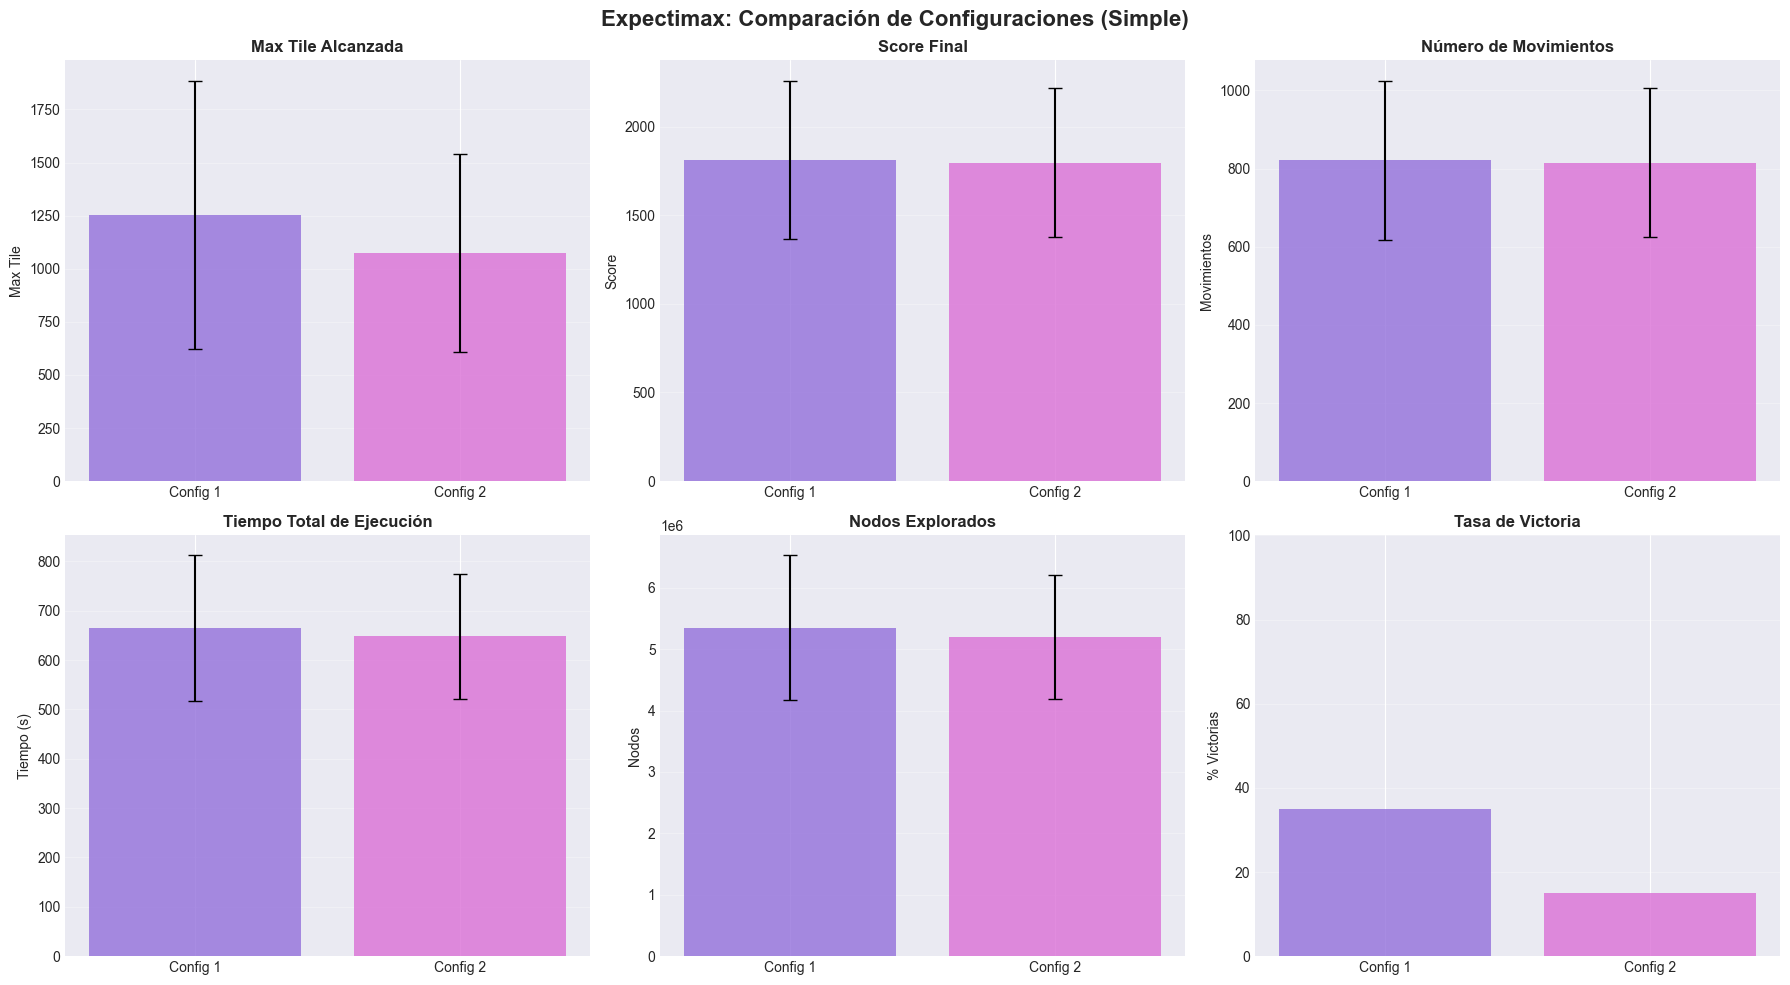

✅ Comparación Expectimax generada (guardada como fig6_expectimax_configurations.png)


In [124]:
# Comparar Expectimax con diferentes configuraciones
expectimax_comp = df_summary[df_summary['algorithm'] == 'expectimax'].copy()

if len(expectimax_comp) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    x_labels = ['Config ' + str(int(c)) for c in expectimax_comp['config']]
    x_pos = range(len(expectimax_comp))
    colors = ['mediumpurple', 'orchid']
    
    # 1. Max Tile
    axes[0].bar(x_pos, expectimax_comp['max_tile_mean'], 
                yerr=expectimax_comp['max_tile_std'], 
                capsize=5, alpha=0.8, color=colors[:len(expectimax_comp)])
    axes[0].set_title('Max Tile Alcanzada', fontweight='bold')
    axes[0].set_ylabel('Max Tile')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(x_labels)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Score Final
    axes[1].bar(x_pos, expectimax_comp['score_mean'], 
                yerr=expectimax_comp['score_std'], 
                capsize=5, alpha=0.8, color=colors[:len(expectimax_comp)])
    axes[1].set_title('Score Final', fontweight='bold')
    axes[1].set_ylabel('Score')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(x_labels)
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Movimientos
    axes[2].bar(x_pos, expectimax_comp['moves_mean'], 
                yerr=expectimax_comp['moves_std'], 
                capsize=5, alpha=0.8, color=colors[:len(expectimax_comp)])
    axes[2].set_title('Número de Movimientos', fontweight='bold')
    axes[2].set_ylabel('Movimientos')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(x_labels)
    axes[2].grid(axis='y', alpha=0.3)
    
    # 4. Tiempo Total
    axes[3].bar(x_pos, expectimax_comp['time_mean'], 
                yerr=expectimax_comp['time_std'], 
                capsize=5, alpha=0.8, color=colors[:len(expectimax_comp)])
    axes[3].set_title('Tiempo Total de Ejecución', fontweight='bold')
    axes[3].set_ylabel('Tiempo (s)')
    axes[3].set_xticks(x_pos)
    axes[3].set_xticklabels(x_labels)
    axes[3].grid(axis='y', alpha=0.3)
    
    # 5. Nodos Explorados
    axes[4].bar(x_pos, expectimax_comp['nodes_mean'], 
                yerr=expectimax_comp['nodes_std'], 
                capsize=5, alpha=0.8, color=colors[:len(expectimax_comp)])
    axes[4].set_title('Nodos Explorados', fontweight='bold')
    axes[4].set_ylabel('Nodos')
    axes[4].set_xticks(x_pos)
    axes[4].set_xticklabels(x_labels)
    axes[4].grid(axis='y', alpha=0.3)
    axes[4].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 6. Tasa de Victoria
    axes[5].bar(x_pos, expectimax_comp['win_rate'], 
                capsize=5, alpha=0.8, color=colors[:len(expectimax_comp)])
    axes[5].set_title('Tasa de Victoria', fontweight='bold')
    axes[5].set_ylabel('% Victorias')
    axes[5].set_xticks(x_pos)
    axes[5].set_xticklabels(x_labels)
    axes[5].set_ylim([0, 100])
    axes[5].grid(axis='y', alpha=0.3)
    
    fig.suptitle('Expectimax: Comparación de Configuraciones (Simple)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/plots/fig6_expectimax_configurations.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Comparación Expectimax generada (guardada como fig6_expectimax_configurations.png)")
else:
    print("⚠️ No hay datos de Expectimax")

### 8. Insights y Conclusiones Clave

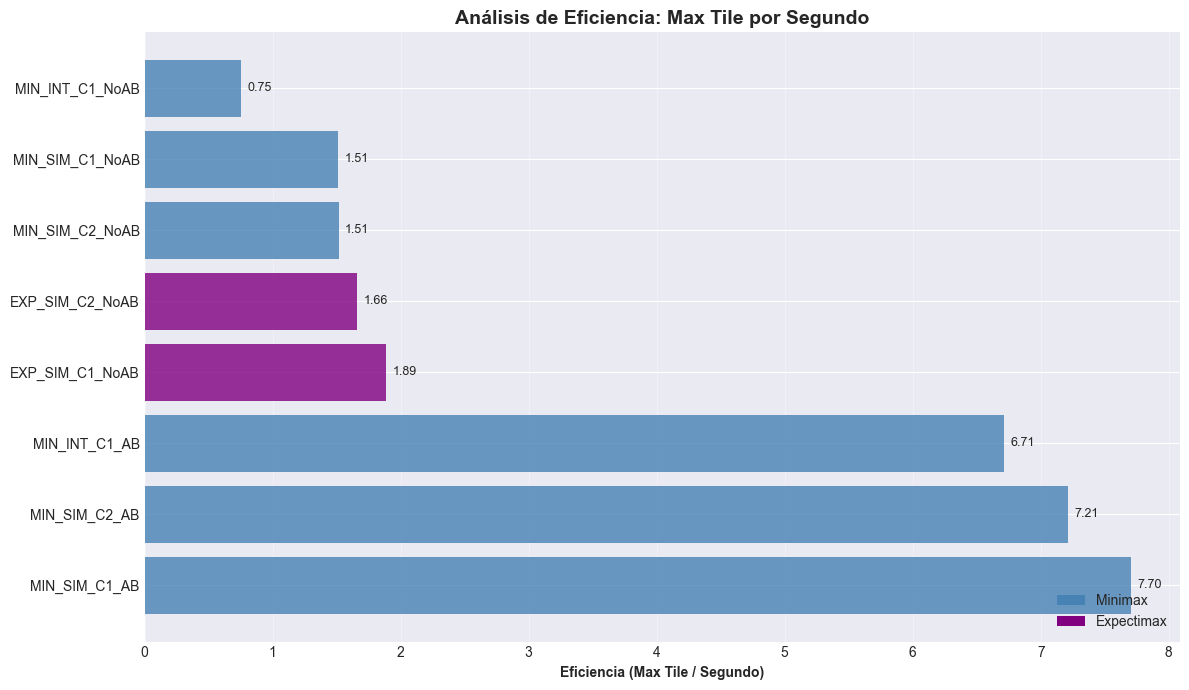

✅ Análisis de eficiencia generado (guardado como fig7_efficiency_analysis.png)


In [125]:
# Gráfico adicional: Eficiencia (Max Tile / Tiempo)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Calcular eficiencia
df_summary['efficiency'] = df_summary['max_tile_mean'] / df_summary['time_mean']

# Ordenar por eficiencia
df_efficiency = df_summary.sort_values('efficiency', ascending=False)

colors_algo = ['steelblue' if alg == 'minimax' else 'purple' for alg in df_efficiency['algorithm']]

bars = ax.barh(range(len(df_efficiency)), df_efficiency['efficiency'], color=colors_algo, alpha=0.8)
ax.set_yticks(range(len(df_efficiency)))
ax.set_yticklabels(df_efficiency['short_label'], fontsize=10)
ax.set_xlabel('Eficiencia (Max Tile / Segundo)', fontweight='bold')
ax.set_title('Análisis de Eficiencia: Max Tile por Segundo', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Añadir valores
for i, (idx, row) in enumerate(df_efficiency.iterrows()):
    ax.text(row['efficiency'] + 0.05, i, f"{row['efficiency']:.2f}", 
            va='center', fontsize=9)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Minimax'),
    Patch(facecolor='purple', label='Expectimax')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('results/plots/fig7_efficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Análisis de eficiencia generado (guardado como fig7_efficiency_analysis.png)")

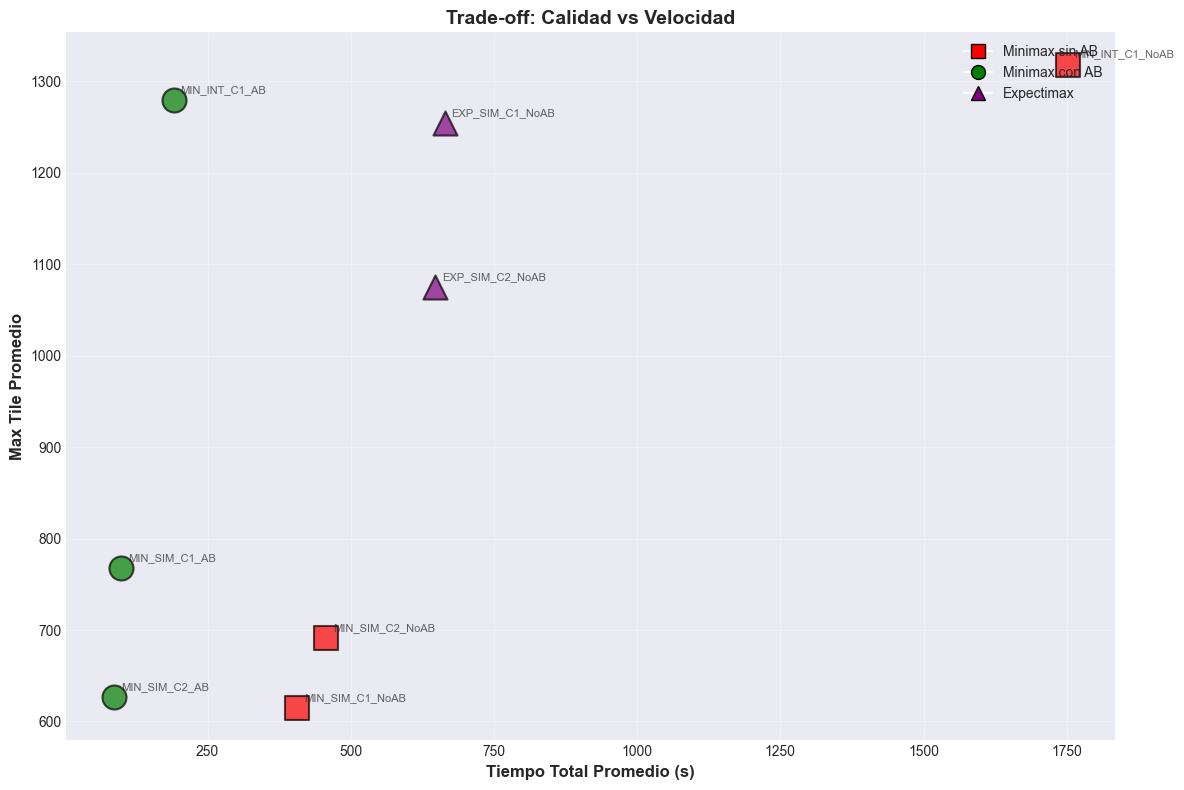

✅ Gráfico de trade-off generado (guardado como fig8_quality_vs_speed_tradeoff.png)


In [126]:
# Gráfico adicional: Trade-off Calidad vs Velocidad (Scatter plot)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Colores por algoritmo
colors_scatter = []
markers_list = []
for idx, row in df_summary.iterrows():
    if row['algorithm'] == 'minimax':
        if row['alpha_beta']:
            colors_scatter.append('green')
            markers_list.append('o')  # círculo
        else:
            colors_scatter.append('red')
            markers_list.append('s')  # cuadrado
    else:  # expectimax
        colors_scatter.append('purple')
        markers_list.append('^')  # triángulo

# Crear scatter plot
for i, (idx, row) in enumerate(df_summary.iterrows()):
    ax.scatter(row['time_mean'], row['max_tile_mean'], 
              s=300, c=colors_scatter[i], marker=markers_list[i], 
              alpha=0.7, edgecolors='black', linewidth=1.5,
              label=row['short_label'])

ax.set_xlabel('Tiempo Total Promedio (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Max Tile Promedio', fontsize=12, fontweight='bold')
ax.set_title('Trade-off: Calidad vs Velocidad', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Añadir anotaciones para puntos clave
for idx, row in df_summary.iterrows():
    ax.annotate(row['short_label'], 
                (row['time_mean'], row['max_tile_mean']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7)

# Leyenda personalizada
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', 
           markersize=10, label='Minimax sin AB', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
           markersize=10, label='Minimax con AB', markeredgecolor='black'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='purple', 
           markersize=10, label='Expectimax', markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('results/plots/fig8_quality_vs_speed_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Gráfico de trade-off generado (guardado como fig8_quality_vs_speed_tradeoff.png)")